In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.datasets import load_iris
from sklearn.naive_bayes import GaussianNB
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.metrics import accuracy_score, recall_score, precision_score, plot_confusion_matrix

In [2]:
def plotDecisionBoundary(X, y, est, title='', saveFig=False, filePath=None,
                         encode=False, cls_names=[]):
    plt.close('all')
    plt.figure()
    cmap = 'RdYlBu'
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.02
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = est.predict(np.c_[xx.ravel(), yy.ravel()])
    
    if(encode):
      for idx, element in enumerate(cls_names):
        Z[np.where(element == Z)] = idx

    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.7)
    plt.title(title)
    if(saveFig):
      plt.savefig(filePath, dpi=400)
      
def plot_varsmoothing_accuracy(vals, title=''):
    test_accs = []
    train_accs = []

    for v in vals: 
        nb = GaussianNB(var_smoothing=v)
        nb.fit(X_train, y_train)
        train_score = nb.score(X_train, y_train) * 100
        train_accs.append(train_score)
        test_score = nb.score(X_test, y_test) * 100
        test_accs.append(test_score)

    plt.plot([np.log10(x) for x in VAR_SMOOTHING], train_accs, label="train")
    plt.plot([np.log10(x) for x in VAR_SMOOTHING], test_accs, label="test")

    plt.legend(loc="upper right")
    plt.xlabel("Log 10 Var Smoothing")
    plt.ylabel("Accuracy")
    plt.title(title)

    
def plotDataset(X, y, cls_names, cmap="RdYlBu"):
    colors = ['red', 'orange', 'blue']
    for idx in range(len(cls_names)):
        plt.scatter(X[y == idx, 0], X[y == idx, 1], c=colors[idx],
                    cmap=cmap, label=cls_names[idx])
    plt.legend()
    
def evaluate_classifier(classifier, X, y, avg='binary'):
    preds = classifier.predict(X)
    acc = accuracy_score(y, preds) * 100
    precision = precision_score(y, preds, average=avg)
    recall = recall_score(y, preds, average=avg)
    
    print("Accuracy: ", acc)
    print("Precision: ", precision)
    print("Recall: ", recall)
    
def load_iris(keep_cls=[0,1,2,3]):
    iris = datasets.load_iris()
    X, y = iris.data[:, keep_cls], iris.target
    return X, y, iris.target_names

# 1- Load 2D Iris Dataset

In [3]:
X, y, cls_names = load_iris([0, 1])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

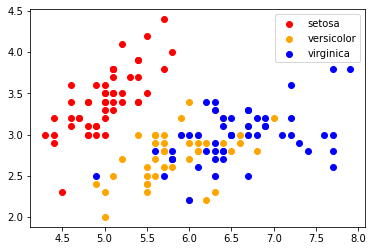

In [4]:
plotDataset(X, y, cls_names)

# 2- Apply Naive Bayes Classifier

In [5]:
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

------------- Training Scores -------------

Accuracy:  81.25
Precision:  0.814968814968815
Recall:  0.8133248025644009


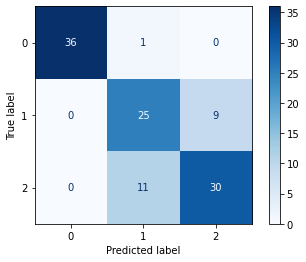

In [6]:
print("------------- Training Scores -------------\n")
evaluate_classifier(nb, X_train, y_train, avg='macro')
plot_confusion_matrix(nb, X_train, y_train, cmap='Blues');

------------- Testing Scores -------------

Accuracy:  76.31578947368422
Precision:  0.7352941176470589
Recall:  0.7314814814814815


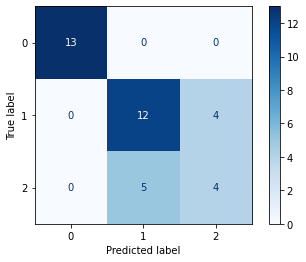

In [7]:
print("------------- Testing Scores -------------\n")
evaluate_classifier(nb, X_test, y_test, avg='macro')
plot_confusion_matrix(nb, X_test, y_test, cmap='Blues');

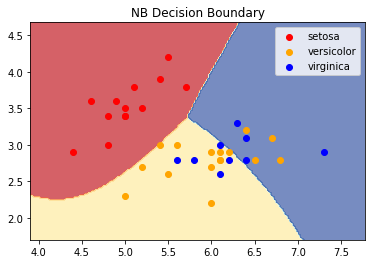

In [8]:
plotDecisionBoundary(X_test, y_test, nb, "NB Decision Boundary")
plotDataset(X_test, y_test, cls_names)
plt.show()

# 4- Tune Naive Bayes

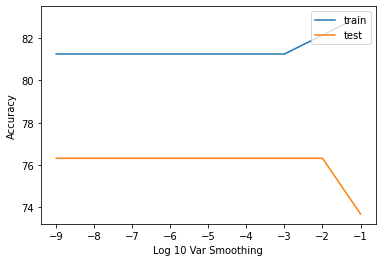

In [9]:
VAR_SMOOTHING = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

plot_varsmoothing_accuracy(VAR_SMOOTHING)

# 5- Develop Risk-Based Bayesian Decision Theory Classifier

In [10]:
'''Adapted from the tutorials'''

class BayesianDecisionTheoryClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, estimator, riskMat):
        self.estimator = estimator
        self.riskMat = riskMat

    def fit(self, X, y, cls_names):
        # Validate inputs
        X, y = check_X_y(X, y)
        
        self.classes_ = cls_names
        self.estimator_ = clone(self.estimator).fit(X, y)
        return self

    def predict_proba(self, X):
        # Perform input and model checks
        check_is_fitted(self)
        X = check_array(X)
        
        prob = self.estimator_.predict_proba(X)
        probList = [(prob * self.riskMat[index]).sum(axis=1).reshape((-1, 1))
                    for index, c in enumerate(self.classes_)]
        prob = np.hstack(probList)
        return prob

    def predict(self, X):
        pred = self.predict_proba(X).argmin(axis=1)
        return self.classes_[pred]

In [11]:
riskMat = np.array([[-10, -5, -5],
                    [-5, -10, -5],
                    [-5, -5, -100]])

In [12]:
rbdtc = BayesianDecisionTheoryClassifier(nb, riskMat)
rbdtc.fit(X_train, y_train, cls_names)

y_train_names = cls_names[y_train] 
y_test_names = cls_names[y_test]

y_train_preds = rbdtc.predict(X_train)
y_test_preds = rbdtc.predict(X_test)

------------- Training Scores -------------

Accuracy:  66.07142857142857
Precision:  0.6752136752136751
Recall:  0.631425543190249


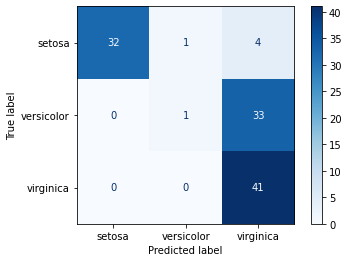

In [13]:
print("------------- Training Scores -------------\n")
evaluate_classifier(rbdtc, X_train, y_train_names, avg='macro')
plot_confusion_matrix(rbdtc, X_train, y_train_names, cmap='Blues');


------------- Testing Scores -------------

Accuracy:  57.89473684210527
Precision:  0.7866666666666666
Recall:  0.6618589743589743


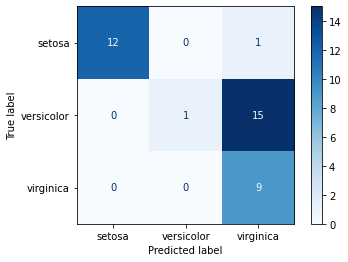

In [14]:
print("------------- Testing Scores -------------\n")
evaluate_classifier(rbdtc, X_test, y_test_names, avg='macro')
plot_confusion_matrix(rbdtc, X_test, y_test_names, cmap='Blues');

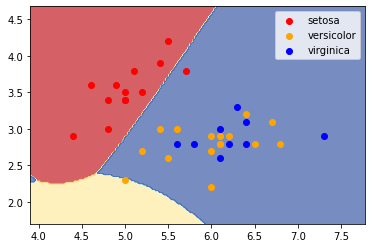

In [15]:
plotDecisionBoundary(X_test, y_test, rbdtc, saveFig=True, 
                     filePath="RBDTC_decision.png", encode=True,
                     cls_names=cls_names)

plotDataset(X_test, y_test, cls_names)
plt.savefig("RBDTC_decision.png", dpi=400)